In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [2]:
dataset = pd.read_csv('front_face.csv')

## 從數值面來看，bmi原始資料看起來挺偏頗的 每一個 bar 之間的距離為 1.00

#### - MatplotLib Display -

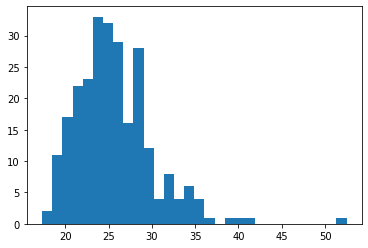

In [12]:
mpl_fig = plt.hist(dataset['bmi-gt'], bins=30)

#### - Plotly Display -

In [11]:
fig = px.histogram(dataset, x='bmi-gt', nbins=30)
fig.show()

### 從類別面來看，資料傾斜更嚴重 

In [4]:
bmi_class = dataset['class-gt'].value_counts()
bmi_cl_df = pd.DataFrame({'bmi_class':bmi_class.index, 'count':bmi_class.values})
fig = px.bar(bmi_cl_df, x='bmi_class', y='count')
fig.show()

## 重新定義 bmi 4 類別

In [5]:
dataset = dataset.sort_values(by=['bmi-gt']).reset_index(drop=True)
dataset.head(3)

,id,height,weight,bmi-gt,class-gt,CJWR,WHR,PAR,ES,FWR,MEH,CFR
0,295712.jpg,1.75,53.07,17.33,a,1.18,1.71,0.03,32.00,1.20,22.30,36.90
1,293757.jpg,1.88,63.50,17.97,a,1.21,1.57,0.02,38.50,1.25,26.16,44.21
2,292182.jpg,1.70,54.43,18.83,b,1.19,1.65,0.02,38.08,1.24,25.54,40.30


In [6]:
bmi_class_thr = np.quantile(dataset['bmi-gt'], [.25, .5, .75])
def bmi_classifier(val, thresholds: list):
    if val < thresholds[0]:
        return 'a'
    elif thresholds[0] <= val < thresholds[1]:
        return 'b'
    elif thresholds[1] <= val < thresholds[2]:
        return 'c'
    else:
        return 'd'

dataset['class-gt-new'] = dataset['bmi-gt'].apply(bmi_classifier, args=(bmi_class_thr,))
dataset = shuffle(dataset).reset_index(drop=True)
dataset

,id,height,weight,bmi-gt,class-gt,CJWR,WHR,PAR,ES,FWR,MEH,CFR,class-gt-new
0,290250.jpg,1.88,94.35,26.69,c,1.23,1.66,0.02,43.00,1.28,25.92,40.13,c
1,293221.jpg,1.78,129.27,40.80,d,1.16,1.79,0.02,42.00,1.51,29.22,47.92,d
2,291569.jpg,1.73,68.04,22.73,b,1.21,1.61,0.02,35.00,1.47,22.99,50.54,b
3,295634.jpg,1.70,74.84,25.90,c,1.25,1.62,0.02,40.49,1.33,39.98,41.83,c
4,291499.jpg,1.68,68.04,24.11,b,1.24,1.72,0.02,44.00,1.39,36.92,38.82,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,293727.jpg,1.68,68.04,24.11,b,1.17,1.54,0.02,41.50,1.28,40.79,41.61,b
252,294215.jpg,1.68,54.43,19.29,b,1.30,1.57,0.03,33.00,1.32,29.45,38.19,a
253,295933.jpg,1.70,54.43,18.83,b,1.19,1.66,0.02,36.51,1.36,27.80,42.56,a
254,293607.jpg,1.91,104.33,28.60,c,1.19,1.44,0.02,39.50,1.29,35.28,44.20,d


#### 新的 bmi-class 分布

In [7]:
bmi_class = dataset['class-gt-new'].value_counts()
bmi_cl_df = pd.DataFrame({'bmi_class':bmi_class.index, 'count':bmi_class.values})
bmi_cl_df

,bmi_class,count
0,d,65
1,c,65
2,b,63
3,a,63


In [8]:
fig = px.bar(bmi_cl_df, x='bmi_class', y='count')
fig.show()

# 開始對新的類別進行 SVC 預測

#### 切出 train data and test data

In [9]:
test_size = 0.33
feat_list = ['CJWR', 'WHR', 'PAR', 'ES', 'FWR', 'MEH', 'CFR']
X = dataset.loc[:, feat_list].values
y = dataset['class-gt-new'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=99)

#### 欲調配的 Kernel 與參數組合

In [10]:
tuned_parameters = [
    {'kernel': ['rbf'],
     'gamma': [0.01, 0.05, 0.1, 0.5, 10, 1e-3, 1e-4],
     'C': [0.01, 0.05, 0.1, 0.5, 10, 100]
    },

    {'kernel': ['linear'],
     'C': [0.01, 0.05, 0.1, 0.5, 10, 100]
    },

    {'kernel': ['poly'],
     'degree': [0, 1, 2, 3, 4, 5, 6],
     'C': [0.01, 0.05, 0.1, 0.5, 10, 100]
    }
]

#### Start Tuning

In [11]:
clf = GridSearchCV(
    SVC(), tuned_parameters, 
)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print()

print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("{} (+/- {}) for {}".format(mean, std * 2, params))

print('Finishing Searching\n')
print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.\n")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:
{'C': 0.05, 'degree': 5, 'kernel': 'poly'}

Grid scores on development set:
0.22756302521008404 (+/- 0.10804200079347166) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.2749579831932773 (+/- 0.1099185361917875) for {'C': 0.01, 'gamma': 0.05, 'kernel': 'rbf'}
0.25159663865546217 (+/- 0.07212101341655215) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.22806722689075629 (+/- 0.05733630133840778) for {'C': 0.01, 'gamma': 0.5, 'kernel': 'rbf'}
0.23983193277310924 (+/- 0.025413187457392676) for {'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}
0.2566386554621849 (+/- 0.11702886801741955) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.274453781512605 (+/- 0.12201078763772824) for {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
0.22756302521008404 (+/- 0.10804200079347166) for {'C': 0.05, 'gamma': 0.01, 'kernel': 'rbf'}
0.2749579831932773 (+/- 0.1099185361917875) for {'C': 0.05, 'gamma': 0.05, 'kernel': 'rbf'}
0.25159663865546217 (+/- 0.072121013416

#### Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred)

array([[ 4, 13,  0,  2],
       [ 2, 13,  2,  2],
       [ 3, 18,  1,  0],
       [ 1, 17,  0,  7]], dtype=int64)

In [13]:
y_true

array(['b', 'c', 'b', 'c', 'd', 'c', 'd', 'b', 'a', 'b', 'a', 'a', 'c',
       'c', 'c', 'b', 'b', 'c', 'c', 'a', 'd', 'c', 'a', 'c', 'a', 'd',
       'b', 'd', 'b', 'c', 'c', 'a', 'b', 'b', 'd', 'c', 'c', 'b', 'a',
       'c', 'd', 'd', 'd', 'a', 'c', 'd', 'a', 'd', 'd', 'c', 'b', 'a',
       'b', 'c', 'd', 'c', 'd', 'd', 'd', 'b', 'a', 'a', 'b', 'd', 'a',
       'c', 'd', 'a', 'a', 'd', 'd', 'b', 'd', 'd', 'a', 'd', 'c', 'a',
       'd', 'c', 'b', 'b', 'd', 'b', 'a'], dtype=object)

#### 完全沒預測出 C 類... 或是 C 類超少

In [14]:
y_pred

array(['b', 'c', 'b', 'b', 'b', 'a', 'd', 'a', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'c', 'a', 'a', 'b', 'b', 'b', 'b', 'd', 'b', 'b', 'b',
       'b', 'b', 'd', 'b', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'a',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'd', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'd', 'b', 'a', 'a', 'b', 'a', 'd',
       'b', 'd', 'b', 'b', 'd', 'd', 'c', 'd', 'b', 'b', 'b', 'b', 'a',
       'd', 'b', 'b', 'b', 'b', 'b', 'b'], dtype=object)